# Phenomenon-Target Training (AI Lab Run)
- C01: This is the first version of phenomenon training. In this we generated a sibilant-stop dataset and a stop-dataset. For S-set we constrain that all at word start. For SS-set we allow in-between ones because we know that basically they are also deaspirated. 

## Preparing

In [26]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
from model_model import VQVAEV1 as TheLearner
from model_dataset import DS_Tools
from model_dataset import TargetDataset as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [28]:
rec_dir = train_cut_phone_
# train_guide_path = os.path.join(src_, "guide_train.csv")
# valid_guide_path = os.path.join(src_, "guide_validation.csv")
# test_guide_path = os.path.join(src_, "guide_test.csv")

phi_T_train_path = os.path.join(src_, "phi-T-train.csv")
phi_ST_train_path = os.path.join(src_, "phi-ST-train.csv")
phi_T_valid_path = os.path.join(src_, "phi-T-valid.csv")
phi_ST_valid_path = os.path.join(src_, "phi-ST-valid.csv")

### Constants

In [35]:
BATCH_SIZE = 32

# IN_DIM = 64
# HID_DIM = 8

# ENC_SIZE_LIST = {
#     "in": 64, 
#     "hid": 8
# }
# DEC_SIZE_LIST = {
#     "hid": 8
# }

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5
NUM_LAYERS = 2
EMBEDDING_DIM = 128

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32

## Prepare for this time of training

In [36]:
ts = str(get_timestamp())
# ts = "0225215615"
stop_epoch = "29"
train_name = "C_01"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
train_recon_losses = ListRecorder(os.path.join(model_save_dir, "train.recon.loss"))
train_embedding_losses = ListRecorder(os.path.join(model_save_dir, "train.embedding.loss"))
train_commitment_losses = ListRecorder(os.path.join(model_save_dir, "train.commitment.loss"))

valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))
valid_recon_losses = ListRecorder(os.path.join(model_save_dir, "valid.recon.loss"))
valid_embedding_losses = ListRecorder(os.path.join(model_save_dir, "valid.embedding.loss"))
valid_commitment_losses = ListRecorder(os.path.join(model_save_dir, "valid.commitment.loss"))

text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

C_01-0226154925


- 0225215615: first trial. 
- 0226154925: retrained with speakers separated. 

In [37]:
READ = False
DATAREAD = False

In [46]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

# We do the random selection here
t_train = pd.read_csv(phi_T_train_path)
st_train = pd.read_csv(phi_ST_train_path)
t_valid = pd.read_csv(phi_T_valid_path)
st_valid = pd.read_csv(phi_ST_valid_path)

all_train = pd.concat([t_train, st_train], ignore_index=True, sort=False)
all_valid = pd.concat([t_valid, st_valid], ignore_index=True, sort=False)

all_train = all_train.sample(frac=1).reset_index(drop=True)
all_valid = all_valid.sample(frac=1).reset_index(drop=True)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       all_train, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       all_valid, 
                       mapper=mymap, 
                       transform=mytrans)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [47]:
train_num, valid_num, len(train_loader), len(valid_loader)

(4104, 1116, 129, 35)

torch.Size([32, 18, 64])


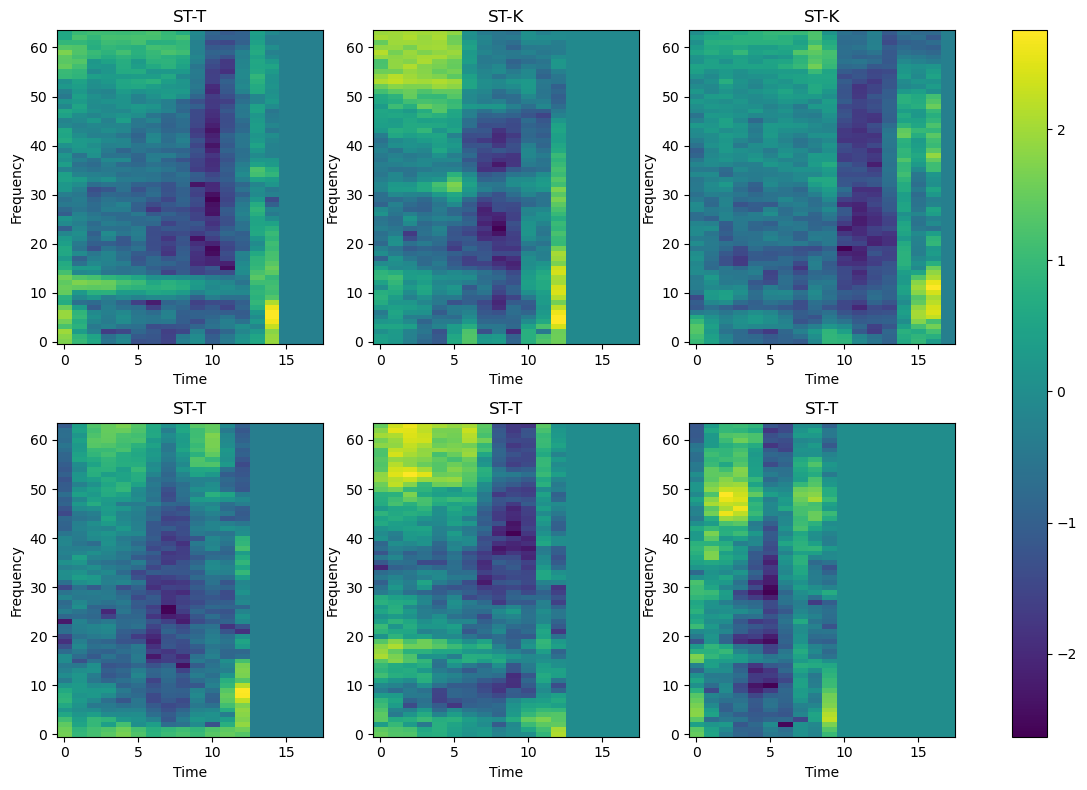

In [48]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens, phi_type, stop_name = sample_data
print(xx_pad.shape)

# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    this_phi_type, this_stop_name = phi_type[idx], stop_name[idx]
    title = "-".join([this_phi_type, this_stop_name])
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Loss
VAE的损失由重构损失和KL损失组成.

KL散度就不再推导了, 直接放结果:
$$KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)$$

VAE的目标是最小化$Z$和$\mathcal{N}(0, I)$之间的KL散度, 代码只需要照着写就行了:

In [50]:
masked_loss = MaskedLoss(loss_fn=nn.MSELoss(reduction="none"))

## Prepare Model
先定义好训练的epoch和batch_size, 优化器随便选一个世界上最好的优化器Adam(lr=1e-3):

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TheLearner(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [52]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.LSTM): 
        for name, p in m.named_parameters():
            if "weight" in name: 
                nn.init.orthogonal_(p)
            elif "bias" in name: 
                nn.init.constant_(p, 0)

model.apply(init_weights)

6960


VQVAEV1(
  (encoder): VQEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): VQDecoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_2): Linear(in_features=8, out_features=64, bias=True)
    (act): ReLU()
  )
  (vq_embedding): Embedding(128, 8)
)

### Load model if READ

In [53]:
if READ: 
    train_losses.read()
    train_recon_losses.read()
    train_embedding_losses.read()
    train_commitment_losses.read()

    valid_losses.read()
    valid_recon_losses.read()
    valid_embedding_losses.read()
    valid_commitment_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Training

In [54]:
l_w_embedding = 1
l_w_commitment = 0.25

In [55]:
EPOCHS = 100
BASE = 0

In [56]:
for epoch in range(BASE, BASE + EPOCHS):
    text_hist.print("Epoch {}".format(epoch))

    model.train()
    train_loss = 0.
    train_cumulative_l_reconstruct = 0.
    train_cumulative_l_embedding = 0.
    train_cumulative_l_commitment = 0.
    train_num = len(train_loader.dataset)    # train_loader
    for idx, (x, x_lens, pt, sn) in enumerate(train_loader):
        current_batch_size = x.shape[0]
        # y_lens should be the same as x_lens
        optimizer.zero_grad()
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        y = x
        x = x.to(device)
        y = y.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        l_reconstruct = masked_loss.get_loss(x_hat, y, x_mask)
        l_embedding = masked_loss.get_loss(ze.detach(), zq, x_mask)
        l_commitment = masked_loss.get_loss(ze, zq.detach(), x_mask)
        loss = l_reconstruct + \
            l_w_embedding * l_embedding + l_w_commitment * l_commitment

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
        optimizer.step()

        train_loss += loss.item() * current_batch_size
        train_cumulative_l_reconstruct += l_reconstruct.item() * current_batch_size
        train_cumulative_l_embedding += l_embedding.item() * current_batch_size
        train_cumulative_l_commitment += l_commitment.item() * current_batch_size

        if idx % 100 == 0:
            text_hist.print(f"""Training step {idx} loss {loss: .3f} \t recon {l_reconstruct: .3f} \t embed {l_embedding: .3f} \t commit {l_commitment: .3f}""")

    train_losses.append(train_loss / train_num)
    train_recon_losses.append(train_cumulative_l_reconstruct / train_num)
    train_embedding_losses.append(train_cumulative_l_embedding / train_num)
    train_commitment_losses.append(train_cumulative_l_commitment / train_num)

    text_hist.print(f"""※※※Training loss {train_loss / train_num: .3f} \t recon {train_cumulative_l_reconstruct / train_num: .3f} \t embed {train_cumulative_l_embedding / train_num: .3f} \t commit {train_cumulative_l_commitment / train_num: .3f}※※※""")

    last_model_name = "{}.pt".format(epoch)
    torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


    model.eval()
    valid_loss = 0.
    valid_cumulative_l_reconstruct = 0.
    valid_cumulative_l_embedding = 0.
    valid_cumulative_l_commitment = 0.
    valid_num = len(valid_loader.dataset)
    for idx, (x, x_lens, pt, sn) in enumerate(valid_loader):
        current_batch_size = x.shape[0]
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)

        y = x
        x = x.to(device)
        y = y.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        l_reconstruct = masked_loss.get_loss(x_hat, y, x_mask)
        l_embedding = masked_loss.get_loss(ze.detach(), zq, x_mask)
        l_commitment = masked_loss.get_loss(ze, zq.detach(), x_mask)
        loss = l_reconstruct + \
            l_w_embedding * l_embedding + l_w_commitment * l_commitment

        valid_loss += loss.item() * current_batch_size
        valid_cumulative_l_reconstruct += l_reconstruct.item() * current_batch_size
        valid_cumulative_l_embedding += l_embedding.item() * current_batch_size
        valid_cumulative_l_commitment += l_commitment.item() * current_batch_size

    text_hist.print(f"""※※※Valid loss {valid_loss / valid_num: .3f} \t recon {valid_cumulative_l_reconstruct / valid_num: .3f} \t embed {valid_cumulative_l_embedding / valid_num: .3f} \t commit {valid_cumulative_l_commitment / valid_num: .3f}※※※""")
    valid_losses.append(valid_loss / valid_num)
    valid_recon_losses.append(valid_cumulative_l_reconstruct / valid_num)
    valid_embedding_losses.append(valid_cumulative_l_embedding / valid_num)
    valid_commitment_losses.append(valid_cumulative_l_commitment / valid_num)

Epoch 0
Training step 0 loss  1.001 	 recon  1.000 	 embed  0.001 	 commit  0.001
Training step 100 loss  1.740 	 recon  0.847 	 embed  0.714 	 commit  0.714
※※※Training loss  1.339 	 recon  0.924 	 embed  0.333 	 commit  0.333※※※
※※※Valid loss  1.263 	 recon  0.886 	 embed  0.302 	 commit  0.302※※※
Epoch 1
Training step 0 loss  1.327 	 recon  0.802 	 embed  0.420 	 commit  0.420
Training step 100 loss  0.918 	 recon  0.730 	 embed  0.151 	 commit  0.151
※※※Training loss  0.967 	 recon  0.775 	 embed  0.154 	 commit  0.154※※※
※※※Valid loss  0.834 	 recon  0.780 	 embed  0.043 	 commit  0.043※※※
Epoch 2
Training step 0 loss  0.805 	 recon  0.735 	 embed  0.056 	 commit  0.056
Training step 100 loss  0.801 	 recon  0.775 	 embed  0.021 	 commit  0.021
※※※Training loss  0.784 	 recon  0.739 	 embed  0.036 	 commit  0.036※※※
※※※Valid loss  0.778 	 recon  0.767 	 embed  0.009 	 commit  0.009※※※
Epoch 3
Training step 0 loss  0.774 	 recon  0.753 	 embed  0.017 	 commit  0.017
Training step 1

觉得Loss位数保留太多的可以自己设置.

下面画出训练过程中训练集和验证集上的损失曲线:

In [57]:
train_losses.save()
train_recon_losses.save()
train_embedding_losses.save()
train_commitment_losses.save()
valid_losses.save()
valid_recon_losses.save()
valid_embedding_losses.save()
valid_commitment_losses.save()

Text(0.5, 1.0, 'Learning Curve Commitment Loss')

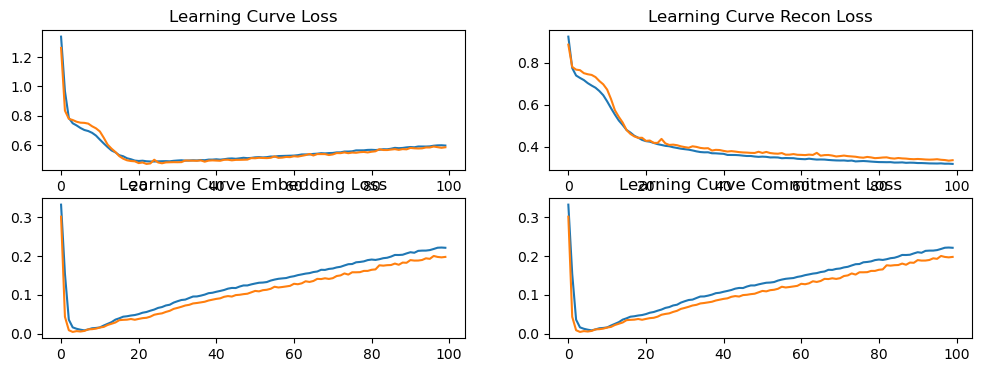

In [58]:
start, end = 0, 100

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 4))
# Plot Loss on the left subplot
ax1.plot(train_losses.get()[start:end], label='Train')
ax1.plot(valid_losses.get()[start:end], label='Valid')
ax1.set_title("Learning Curve Loss")

# Plot Recon Loss on the right subplot
ax2.plot(train_recon_losses.get()[start:end], label='Train')
ax2.plot(valid_recon_losses.get()[start:end], label='Valid')
ax2.set_title("Learning Curve Recon Loss")

# Plot Embedding Loss on the left subplot
ax3.plot(train_embedding_losses.get()[start:end], label='Train')
ax3.plot(valid_embedding_losses.get()[start:end], label='Valid')
ax3.set_title("Learning Curve Embedding Loss")

# Plot Commitment Loss on the right subplot
ax4.plot(train_commitment_losses.get()[start:end], label='Train')
ax4.plot(valid_commitment_losses.get()[start:end], label='Valid')
ax4.set_title("Learning Curve Commitment Loss")

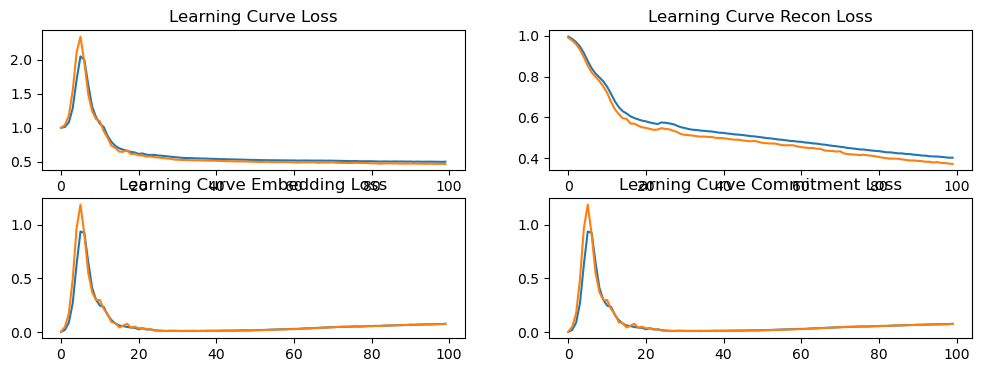

In [59]:
l_reconstruct, l_embedding, l_commitment

(tensor(0.3751, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1747, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1747, device='cuda:0', grad_fn=<DivBackward0>))

基本上Valid Loss稳定了(其实还有下降空间). 同时要保存在验证集上结果最好的模型, 因为等会还要用最好的模型做生成.

In [60]:
ts

'0226154925'